In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

import torch
from momentfm import MOMENTPipeline

c:\Users\admin\anaconda3\envs\momentts_env\Lib\site-packages\transformers\utils\generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
df = pd.read_csv("processed_reflectance.csv")
df_all = df.sort_values("timestamp").reset_index(drop=True)

spec_cols = [c for c in df_all.columns if c != "timestamp"]

df_all

,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
1,2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2,2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
3,2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
4,2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2741,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
def plot_reflectance_heatmap(df, spectral_prefix="", 
                             wl_start=400, cmap="RdYlGn",
                             vmin=-0.075, vmax=0.275,
                             title="Reflectance Variation Over Time",
                             figsize=(10,7)):
    """
    Plot time × wavelength reflectance heatmap.
    df must contain a 'timestamp' column and spectral_bin_* columns.
    """

    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    # Spectral columns
    spec_cols = [c for c in df.columns if c != "timestamp"]
    if len(spec_cols) == 0:
        raise ValueError(f"No columns starting with '{spectral_prefix}' found.")

    # Convert values → matrix
    data = df[spec_cols].to_numpy()

    # Wavelength axis
    wl_end = wl_start + len(spec_cols) - 1
    wavelengths = np.arange(wl_start, wl_end + 1)

    # Date labels
    dates = pd.to_datetime(df["timestamp"]).dt.strftime("%Y-%m-%d")

    # Plot
    plt.figure(figsize=figsize)

    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[wavelengths[0], wavelengths[-1], len(df), 0],
        origin='upper'      # time runs from top to bottom
    )

    plt.colorbar(label="Reflectance")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Date")
    plt.title(title, fontsize=14)

    # Y-ticks → readable dates
    yticks = np.linspace(0, len(df)-1, 10).astype(int)
    plt.yticks(yticks, dates.iloc[yticks], rotation=0)

    plt.tight_layout()
    plt.show()

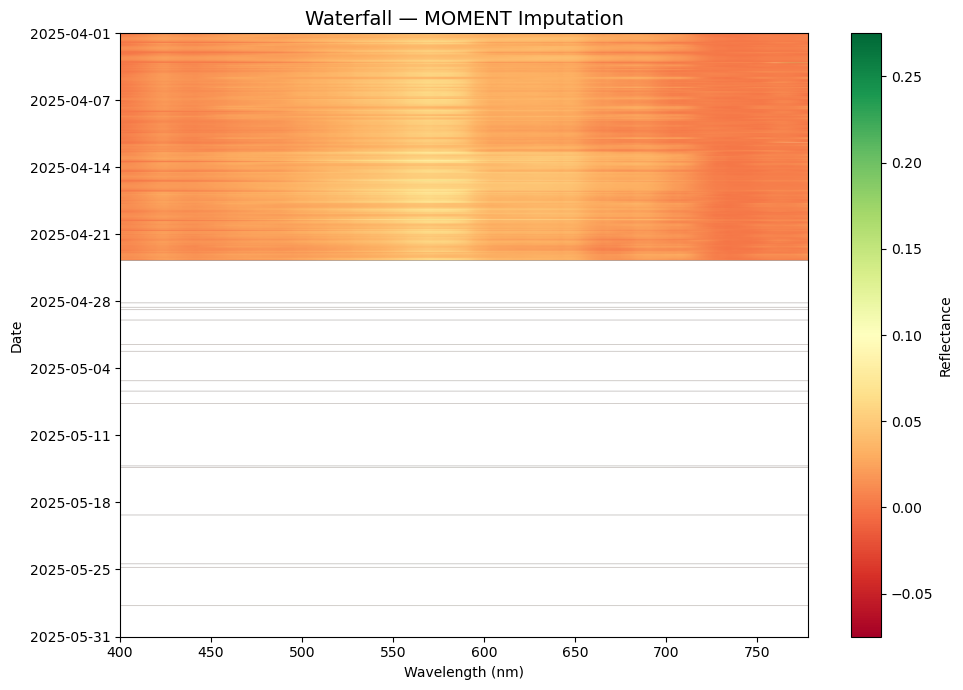

In [4]:
plot_reflectance_heatmap(df, title="Waterfall — MOMENT Imputation")

In [5]:
def interpolate_spectrum_fill_all(y, smooth=True, window=15, poly=3):
    """
    y: 1D array of shape (n_wavelengths,), may contain np.nan.
    Fills *all* gaps (NaNs) in a partially valid spectrum.

    - uses linear interpolation along wavelength
    - extrapolates edges with nearest valid value
    - optional Savitzky–Golay smoothing on the filled curve
    """
    y = y.astype(float)
    x = np.arange(len(y))

    mask = ~np.isnan(y)
    n_valid = mask.sum()

    # No or almost no information → return as is (still NaN)
    if n_valid < 2:
        return y

    x_valid = x[mask]
    y_valid = y[mask]

    # Linear interpolation + edge extrapolation
    # np.interp fills interior by interpolation and outside with boundary values
    y_filled = np.interp(x, x_valid, y_valid)

    if smooth:
        # apply gentle smoothing on the fully filled curve
        if len(y_filled) >= window:
            y_smooth = savgol_filter(y_filled, window_length=window, polyorder=poly)
            return y_smooth
        else:
            # not enough points for this window length
            return y_filled

    return y_filled

# df: your original DataFrame
# spec_cols: list of spectral_bin_* columns, e.g.:
# spec_cols = [c for c in df.columns if c.startswith("spectral_bin_")]

df_processed = df.copy()

is_fully_nan = df_processed[spec_cols].isna().all(axis=1)
is_partially_nan = df_processed[spec_cols].isna().any(axis=1) & ~is_fully_nan

rows_to_work_on = df_processed[is_partially_nan].index

for idx in rows_to_work_on:
    row = df_processed.loc[idx, spec_cols].to_numpy(dtype=float)

    # fill all gaps in that row across all bins
    row_filled = interpolate_spectrum_fill_all(
        row,
        smooth=True,   # set to False if you don’t want smoothing
        window=15,
        poly=3
    )

    df_processed.loc[idx, spec_cols] = row_filled

print("Per-row interpolation complete (all gaps filled in partial rows).")

# Keep fully-NaN rows as they are
df_ready_for_moment = df_processed.sort_values("timestamp").reset_index(drop=True)

print("\nData is now ready.")
print(f"Total rows: {len(df_ready_for_moment)}")
print(
    "Rows with full gaps (still NaN):",
    df_ready_for_moment[spec_cols].isna().all(axis=1).sum()
)

df = df_ready_for_moment.copy()
df

Per-row interpolation complete (all gaps filled in partial rows).

Data is now ready.
Total rows: 2745
Rows with full gaps (still NaN): 1696


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
1,2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2,2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
3,2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
4,2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2740,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2741,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2742,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2743,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


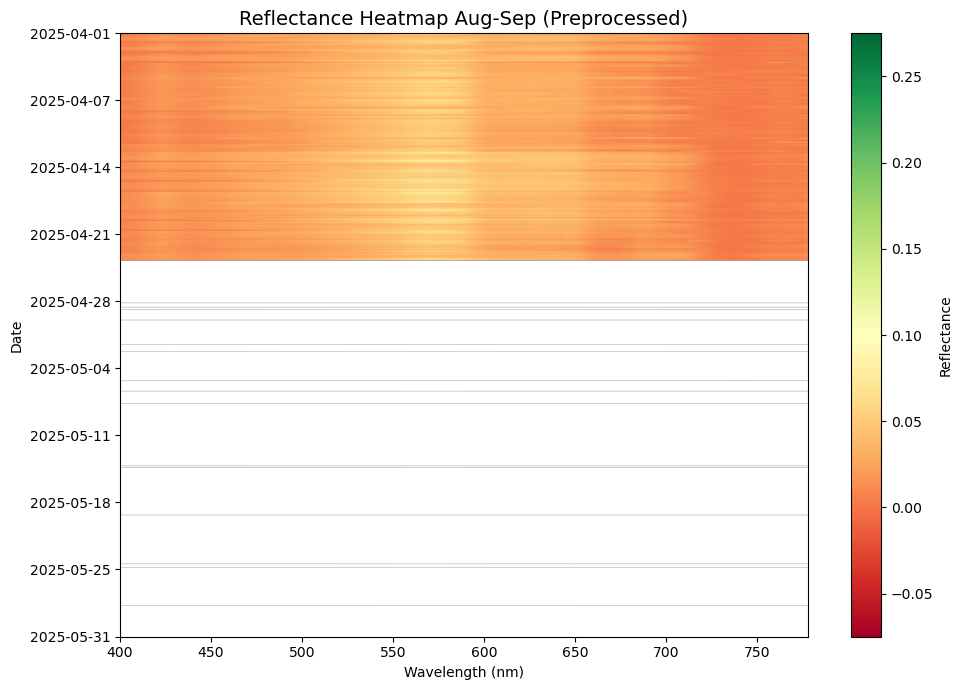

In [6]:
plot_reflectance_heatmap(
    df,
    title="Reflectance Heatmap Aug-Sep (Preprocessed)",
)

In [7]:
#df = df_all.copy()                          # your merged dataframe
df = df_ready_for_moment.sort_values("timestamp").set_index("timestamp")

# A. choose your spectral channels
spec_cols = [c for c in df.columns if c != "timestamp"]
T = len(df)

# B. build a uniform time grid (if not already)
#df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="15min"))

# C. per-channel z-score stats (ignore NaN)
mu = np.nanmean(df[spec_cols].values, axis=0)
sd = np.nanstd(df[spec_cols].values, axis=0) + 1e-6

X_spec = df[spec_cols].values.astype(np.float32)         # [T, C]
mask_spec = np.isnan(X_spec)                             # True where missing
X_fill = np.nan_to_num(X_spec, nan=0.0)                  # temporary fill for encoder
# X_norm = (X_fill - mu) / sd                              # z-score per channel

# D. windowing (MOMENT examples use length=512; choose a value that covers gaps)
win = 512
stride = win          # non-overlapping; you can use smaller stride for overlap
starts = np.arange(0, T - win + 1, stride)

# E. build batched tensors (with padding and overlap)
Xs = []
Ms = []

# Pad the series to be a multiple of the stride for easier windowing
if T % stride != 0:
    pad_len = stride - (T % stride)
    X_fill_padded = np.pad(X_fill, ((0, pad_len), (0, 0)), 'constant', constant_values=0)
    mask_spec_padded = np.pad(mask_spec, ((0, pad_len), (0, 0)), 'constant', constant_values=True) # Pad with True (missing)
else:
    X_fill_padded = X_fill
    mask_spec_padded = mask_spec

T_padded = X_fill_padded.shape[0]
starts = np.arange(0, T_padded - win + 1, stride)

for s in starts:
    seg = X_fill_padded[s:s+win, :]      # [win, C]
    mseg = mask_spec_padded[s:s+win, :]  # [win, C]
    
    # Reshape to [B, n_channels, T] = [1, C, win] → then flatten channels
    seg = np.transpose(seg, (1, 0))      # [C, win]
    mseg = np.transpose(mseg, (1, 0))    # [C, win]
    Xs.append(seg[:, None, :])           # [C, 1, win]
    Ms.append(mseg[:, None, :])          # [C, 1, win]

X_batch = np.concatenate(Xs, axis=0)     # [sum_windows*C, 1, win]
M_batch = np.concatenate(Ms, axis=0)     # same shape, bool

# F) load MOMENT and run inference (This part is correct)
pipe = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={"task_name": "reconstruction"}
)
pipe.init()
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device).float()
pipe.eval()

# 1 for observed, 0 for missing
pretrain_mask = (~M_batch).astype(np.int64)
pretrain_mask = torch.tensor(pretrain_mask.squeeze(1), device=device) # [B*, win]

# Attend everywhere
input_mask = torch.ones_like(pretrain_mask)

with torch.no_grad():
    x_enc = torch.tensor(X_batch, dtype=torch.float32, device=device) # [B*, 1, win]
    out = pipe(x_enc=x_enc, input_mask=input_mask, mask=pretrain_mask)

recon = out.reconstruction.detach().cpu().numpy() # [B*, 1, win]
recon = recon.squeeze(1)                           # -> [B*, win]

# --- Corrected Stitching (with overlap handling) ---
imputed_padded = np.zeros_like(X_fill_padded)
counts = np.zeros_like(X_fill_padded)
ptr = 0

for s in starts:
    # Extract the block of imputed windows for all channels
    block = recon[ptr : ptr + len(spec_cols), :]  # [C, win]
    block = block.T                              # -> [win, C]
    
    # Add the imputed values to the corresponding slice and update the count
    imputed_padded[s : s + win, :] += block
    counts[s : s + win, :] += 1
    
    ptr += len(spec_cols)

# Average the contributions in the overlapping regions
# Add a small epsilon to counts to avoid division by zero
imputed_padded /= (counts + 1e-8)

# Remove padding to match original length
imputed = imputed_padded[:T, :]

# --- Finalize Imputation ---
# Fill only the originally missing values
filled = X_spec.copy()
filled[mask_spec] = imputed[mask_spec]

# Back to DataFrame
df_imputed = df.copy()
# Ensure imputed values are non-negative (reflectance cannot be negative)
df_imputed[spec_cols] = np.clip(filled, 0, None)

In [8]:
df_imputed[spec_cols].isna().sum().sum() # make sure no NaNs remain
df_imputed

,400,401,402,403,404,405,406,407,408,409,...,769,770,771,772,773,774,775,776,777,778
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-04-01 07:00:00+07:00,0.001028,0.001252,0.001631,0.002151,0.002798,0.003557,0.004413,0.005351,0.006358,0.007418,...,0.003903,0.003545,0.003151,0.002730,0.002288,0.001835,0.001377,0.000924,0.000483,0.000062
2025-04-01 07:15:00+07:00,0.001816,0.001444,0.001316,0.001411,0.001710,0.002191,0.002834,0.003618,0.004524,0.005529,...,0.006354,0.006246,0.006138,0.006045,0.005977,0.005948,0.005969,0.006055,0.006216,0.006466
2025-04-01 07:30:00+07:00,0.005216,0.004338,0.003764,0.003469,0.003430,0.003620,0.004017,0.004596,0.005331,0.006200,...,0.005148,0.004928,0.004743,0.004613,0.004555,0.004590,0.004736,0.005012,0.005437,0.006030
2025-04-01 07:45:00+07:00,0.001160,0.000594,0.000311,0.000288,0.000499,0.000921,0.001528,0.002296,0.003201,0.004218,...,0.002718,0.002488,0.002314,0.002204,0.002167,0.002213,0.002352,0.002591,0.002941,0.003412
2025-04-01 08:00:00+07:00,0.003187,0.003371,0.003642,0.003994,0.004419,0.004912,0.005466,0.006074,0.006729,0.007424,...,0.003281,0.003293,0.003316,0.003346,0.003383,0.003424,0.003468,0.003512,0.003555,0.003595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-31 17:00:00+07:00,0.016211,0.015250,0.014449,0.013803,0.013306,0.012954,0.012740,0.012659,0.012707,0.012877,...,0.007576,0.007732,0.007982,0.008336,0.008803,0.009393,0.010115,0.010977,0.011991,0.013165
2025-05-31 17:15:00+07:00,0.016220,0.015258,0.014457,0.013811,0.013315,0.012962,0.012748,0.012668,0.012715,0.012885,...,0.007585,0.007741,0.007991,0.008345,0.008812,0.009402,0.010123,0.010986,0.012000,0.013173
2025-05-31 17:30:00+07:00,0.016209,0.015247,0.014446,0.013800,0.013304,0.012951,0.012737,0.012657,0.012704,0.012874,...,0.007574,0.007730,0.007980,0.008334,0.008801,0.009390,0.010112,0.010975,0.011988,0.013162


In [9]:
df_imputed.to_csv("imputed_MOMENT_without_finetune.csv", index=True)

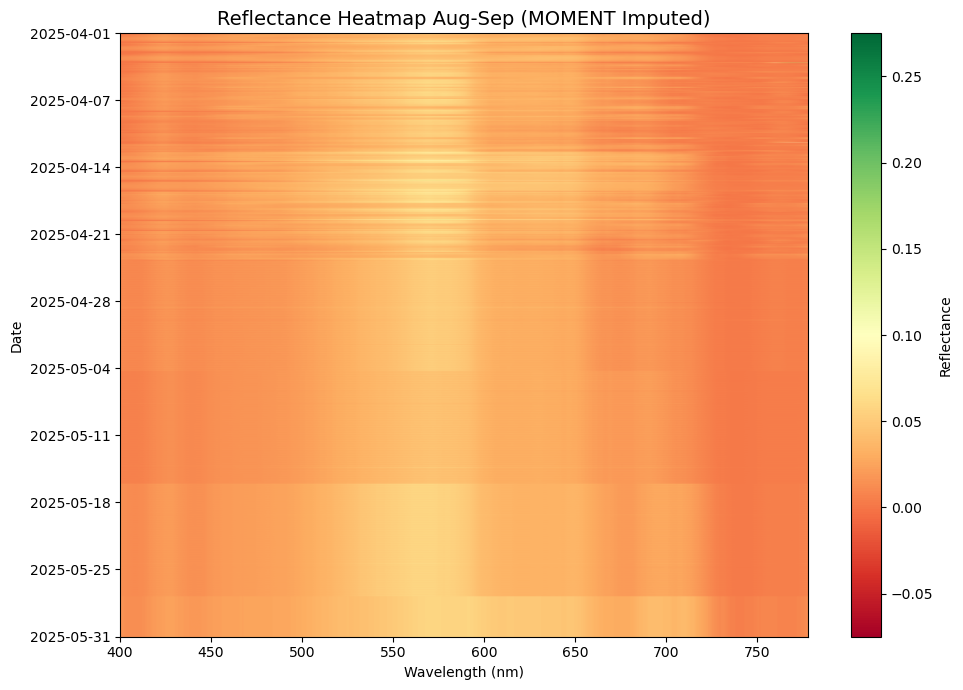

In [10]:
df_imputed = df_imputed.reset_index()
plot_reflectance_heatmap(
    df_imputed,
    title="Reflectance Heatmap Aug-Sep (MOMENT Imputed)",
)
